# K-Means clustering from scratch
Author: [Ryan Parker](https://github.com/rparkr)  
In this notebook, I implement a vectorized version of the k-means clustering algorithm and use it to create color palettes from an input image. Like the other notebooks in my _ML from scratch_ series, I implemented the algorithm without referencing anyone else's code, as an exercise for me to deeply understand common ML techniques.

K-Means is an algorithm that finds groups, or _clusters_, in a dataset by:
1. choosing $k$ starting data points as the cluster centers
2. assigning all remaining data points to a cluster based on the cluster center nearest to them
3. computing the new cluster center as the mean of all the points in that cluster
4. repeating steps 2-3 until convergence, which occurs when no points are reassigned after successive iterations

**What is it useful for?**  
Clustering algorithms are _unsupervised_: there is no label, or target, to predict. Instead, the algorithm seeks to find a pattern in the data, which can help group data into simlar categories. Some example uses of clustering include:
- find related items (products, articles, observations) to an item of interest
- group text documents, like comments or reviews, into categories (topic modeling)
- segment customers
- compress images by reducing the colors used
- categorize transactions

**Demonstrations**

|            Demo data           |           Color palettes          |
|:------------------------------:|:---------------------------------:|
|<img src="../images/kmeans.png">|  <img src="../images/kmeans.png"> |

# Setup
Import required packages and create a sample dataset.

I implement the algorithm using only `numpy`, but I use `matplotlib` for visualization, `sklearn` for creating a sample dataset, `pillow` for loading images into `numpy` arrays, and `tqdm` for creating progress bars during model fit.

In [136]:
# Built-in modules
from pathlib import Path  # create a folder for saving animation images showing plot progress
import sys  # check whether the code is run in a Jupyter notebook (for the animated plot function)
import time  # pause code execution, for creating plot animations
import urllib.request  # download images using urllib.request.urlopen()
# Ignore the "mean of empty slice" RuntimeWarning issued by NumPy when a cluster has no points assigned to it
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# External packages
import IPython # create simple animations using multiple Matplotlib plots and the display.clear_output function
import matplotlib.colors # for accessing color names and choosing color palettes
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle  # for drawing boxes to label bars on plots
import numpy as np
from PIL import Image  # the pillow package for loading images into np arrays
from sklearn.datasets import make_classification
from tqdm.auto import tqdm # display progress bars

# K-Means algorithm
In this section, I define a class that implements the k-means clustering algorithm.

In [306]:
class KMeans():
    def __init__(
            self,
            k: int=4,
            n_rounds: int=10,
            max_iter: int=300,
            threshold: float=0.001,
            cluster_axis: int=-1,
            save_hist: bool=False,
            verbose: bool=False,
            random_state=None) -> None:
        '''Create an object to perform K-Means clustering on a dataset.

        To determine clusters, the K-Means algorithm:
        1. chooses `k` starting data points as the cluster centers
        2. classifies each data point by the cluster center nearest to it
        3. updates the cluster centers to the mean of all the points in that
           cluster
        4. repeats steps 2-3 until convergence: when cluster centers move less
           than `threshold` or when `max_iter` iterations are reached.
        
        # Parameters
        `k`: int, default=4
            The number of clusters to create.
        `n_rounds`: int, default=10
            The number of rounds for the clustering algorithm to run, each
            starting with randomly-chosen initial centers. The best-performing
            run will be returned, as determined by the set of clusters that
            minimizes the average squared distance between points and cluster
            centers.
        `max_iter`: int, default=300
            The maximum number of iterations in a single round. If convergence
            isn't reached by this number of iterations, the algorithm will move
            on to the next round.
        `threshold`: float, default=0.001
            Set the stopping criteria for model fit: if the average change
            for all cluster centers from the previous iteration to the current
            iteration is below this threshold, the algorithm is converged
            and no futher iterations will be peformed in the current round.
            Note that the dataset is normalized on a scale of 0-1 prior to
            running the algorithm, so this convergence criteria applies to data
            on that scale. The default threshold of 0.001 is a 0.1% change in
            cluster centers on each dimension.
        `cluster_axis`: int, default=-1
            The axis to use for clustering; all other axes will be treated as
            samples in the row dimension. The KMeans algorithm uses
            a two-dimensional dataset: each row is a sample, and the columns
            are the features for that sample. If the given dataset has
            more than two axes, the data will be reshaped into 2-D prior to
            fitting the KMeans algorithm. The cluster_axis parameter sets the
            axis that will be used as the columns axis for clustering; all other
            axes will be reshaped into the row dimension. For example, an image
            has 3 axes: height, width, RGB. By default, KMeans will reshape
            the height and width axes into the row dimension and will use the
            RGB values as columns, thus creating a reshaped array of shape:
            (height x width, 3) where the clusters are pixels in RGB space.
        `save_hist`: bool, default=False
            Whether to store data on the cluster centroids during each training
            iteration from model fit. Use only when you plan to use the
            `plot_animate()` method to show training progress, since the history
            increases the memory used by the KMeans object.
        `verbose`: bool, default=False
            If `True`, print outputs showing the progress of model fit.
        `random_state`: int, default=None
            If set, this value will be used as the seed when initializing
            cluster centers.
        
        # Attributes
        `best_round_`: the clustering round that had the smallest avg distance
            between points and their assigned cluster centers.
        `centers_`: the centers of the `k` clusters based on the best
            fit learned after performing `n_rounds` of the algorithm.
        `distances_`: the average distance (vector norm) from each cluster
            center to the points assigned to that cluster.
        `data_min_`: the minimum value of the training data passed to .fit().
            Used for normalizing data before running the algorithm.
        `data_max_`: the maximum value of the training data passed to .fit().
            Used for normalizing data before running the algorithm.
        `hist_`: a list of arrays of the cluster centers from each training
            iteration of the best clustering round. Only available if
            `save_hist=True`. Used by the `plot_animate()` method to create
            an animation of training progress.
        `num_iters_`: the number of iterations before convergence in the best
            clustering round.

        # Methods
        `fit(X)`: train the model to learn the best cluster centers based on
            a dataset (`X`, a NumPy array)
        `classify(X)`: assign cluster labels to data based on the cluster
            centers learned through `fit()`
        `predict(X)`: alias for `classify(X)`
        `plot_scatter(X)`: display a Matplotlib scatter plot of the clusters.
        `plot_animate(X)`: display an animated Matplotlib scatter plot showing
            training progress and final cluster assignments. Requires
            `save_hist` to be set to `True` prior to model fit.
        '''
        # Store arguments passed on instantiation
        self.__dict__.update(locals())
    

    def _preprocess(self, data: np.ndarray, normalize: bool = True) -> np.ndarray:
        '''Normalize data and ensure it is in the proper 2-D format.'''
        # Copy the data first to ensure the input data isn't modified
        data = data.copy()
        if data.ndim == 1:
            raise ValueError("Dataset must have ≥2 dimensions; provided dataset has 1 dimension.")
        if data.ndim > 2 or self.cluster_axis not in [-1, data.ndim - 1]:
            if self.verbose: print(f"Reshaping input data from: {data.shape} to ", end='')
            data = np.reshape(data, (-1, data.shape[self.cluster_axis]))
            if self.verbose: print(f"{data.shape}")
        # Normalize data on a scale of 0-1 (based on the original scale of training data seen during .fit())
        if normalize:
            data = (data - self.data_min_) / (self.data_max_ - self.data_min_)
        return data


    def fit(self, data: np.ndarray) -> None:
        '''Learn cluster centers based on a dataset.

        After fitting the model, assign labels to the dataset by running
        `classify(X)`, which returns a NumPy integer array with the label for
        each sample (row) in the provided dataset, `X`.
        
        # Parameters
        `data`: `numpy.ndarray`
            The input array, to be used for grouping into clusters.
        '''
        
        # Store max and min values of training data, used for normalizing
        # Assumes that all feature columns are on a similar scale
        # TODO: consider normalizing based on the min and max values for each column
        self.data_min_ = data.min()
        self.data_max_ = data.max()

        data = self._preprocess(data)

        if self.verbose:
            pbar = tqdm(total=self.n_rounds)

        # Capture the round with the lowest avg distance from points to cluster
        # centers, starting with round 0 (by setting "best" to infinity)
        best_avg_distance = np.inf

        for round in range(self.n_rounds):
            if self.random_state:
                # Increment the random state each iteration to change starting
                # point selection while maintaining deterministic behavior
                self.random_state += 1
            rng = np.random.default_rng(seed=self.random_state)

            # ===============================
            # Select starting cluster centers
            # ===============================
            # Sample one point for each of the cluster centers; array shape: (num_clusters, num_features)
            centers = rng.choice(data, size=self.k, replace=False, shuffle=False)
            # Store in a list so later iterations can compare to prior ones
            centers_list = [centers]

            i = 0
            converged = False
            while not converged:
                if self.verbose:
                    pbar.set_description(f"Round {round + 1}/{self.n_rounds}, iter {i}")

                # Label samples based on closest cluster
                labels, distances = self.classify(
                    data, cluster_centers=centers, preserve_input_shape=False,
                    return_distances=True, preprocess=False)
                
                # =================================
                # Determine the new cluster centers
                # =================================
                # Create a boolean one-hot-encoding of the closest cluster center for each point.
                # Returns a 2d array of shape: (num_samples, num_clusters)
                indices = np.eye(self.k, dtype='bool')[labels]

                # Index the data array to compute the new mean based on the cluster assignments
                # cluster_assignments is a 3d array: (num_samples, num_features, num_clusters), where dim 3 is
                # 0s where the cluster was not assigned and equal to the column values at the assigned cluster.
                cluster_assignments = (data[..., np.newaxis] * indices[:, np.newaxis, :])
                centers = cluster_assignments.mean(axis=0, where=(cluster_assignments != 0)).T
                
                # =========================================
                # Step 5: check for convergence
                # =========================================
                if (np.all(centers == centers_list[-1])
                    or np.all(np.sqrt(np.sum((centers - centers_list[-1]) ** 2, axis=1)) < self.threshold)):
                    # If all points have the same labels as the last iteration or
                    # if cluster centers are within a tolerance of the prior iteration,
                    # the algorithm has converged.
                    converged = True
                else:
                    # Store centroid coordinates in a list for comparison to later iterations when checking for convergence
                    centers_list.append(centers)

                i += 1
                if i >= self.max_iter:
                    print(f"Round {round}, max iter ({self.max_iter:,.0f}) reached. Proceeding to next round.")
                    converged = True
            
            # Store the best-performing round; starting with round 0.
            # Calculate the average distance from each point to its cluster center
            total_dist = np.sum(distances, axis=1) ** 0.5  # square root of sum of squared distances. Shape: (num_samples, num_clusters)
            avg_dists = np.mean(total_dist, axis=0, where=indices)  # shape: (num_clusters,)
            # If a cluster has no points assigned to it the mean is undefined (NaN), hence np.nanmean
            avg_dist = np.nanmean(avg_dists)  # scalar value, not an array
            
            if avg_dist < best_avg_distance:
                best_avg_distance = avg_dist
                self.best_round_ = round  # the round with the lowest avg distance from points to assigned cluster centers
                self.distances_ = avg_dists
                self.centers_ = centers
                self.num_iters_ = i  # iterations until convergence
                if self.save_hist:
                    self.hist_ = centers_list
                
            if self.verbose:
                pbar.update()  # update progress bar at end of round

        if self.verbose:
            pbar.close()  # remove progress bar


    def classify(
            self,
            data: np.ndarray,
            features_selected: list | None=None,
            cluster_centers: np.ndarray | None=None,
            preserve_input_shape: bool=True,
            return_distances: bool=False,
            preprocess: bool=True) -> np.ndarray:
        '''Classify each sample (row) in a dataset by labeling the sample
        with the cluster whose center is nearest to it.

        Returns a NumPy array with the cluster assigned to each sample.

        # Parameters
        `data`: `numpy.ndarray`
            The data to be classified. Must be 2-dimensional or `preprocess`
            must be set to `True` (default).
        `features_selected`: list of int, default=None
            When classifying data using a subset of the features, set this
            parameter to a list of the indices of the features to use, based on
            the 2-D version of the data: that is, the number of features is
            `training_data.shape[cluster_axis]`. For a 2-D array that would be
            the number of columns. For an image (a 3-D array), the default
            setting of `cluster_axis` (axis -1) would leave 3 features, one for
            each color channel, so the `features_selected` list could have
            values 0, 1, and 2.
            This is most useful for visualizing data in two or three dimensions,
            and is used by the plotting functions in this class.
            The default value `None` means that all features will be used.
        `cluster_centers`: np.ndarray, default=None
            If provided, these values will be used when computing the distance
            from each sample data point to the cluster centers. If `None`
            (default), the centers learned during model training (self.centers_)
            will be used.
            This is a 2-D array of shape: (n_clusters, n_features).
        `preserve_input_shape`: bool, default=True
            If `True` (default), the returned array will match the shape of
            the input data if ndims > 2. If `False` or if ndims == 2, a 1-D
            array will be returned with the cluster label for each sample, where
            the number of samples is given by the row dimension in the input
            data; or, if the data has >2 dimensions, the number of samples is
            given by the product of the shape of all axes of the input data
            besides the `cluster_axis` that is set at object initialization.
        `return_distances`: bool, default=False
            Whether to return a tuple of (labels, distances) arrays. Used in the
            .fit() method (model training).
        `preprocess`: bool, default=True
            Whether to normalize the provided data based on the min and max
            values from the training data seen during model fit.
        '''
        if data.ndim == 1:
            raise ValueError("Dataset must have ≥2 dimensions; given dataset has 1 dimension.")
        if preserve_input_shape:
            cluster_axis = self.cluster_axis if self.cluster_axis != -1 else data.ndim - 1
            input_shape = tuple(data.shape[i] for i in range(data.ndim) if i != cluster_axis)
        
        if preprocess:
            data = self._preprocess(data)

        if np.any(cluster_centers):
            centers = cluster_centers
        else:
            centers = self.centers_
        
        if centers.size == 0:
            raise AssertionError("You need to fit the model before you can perform classification. Run KMeans.fit(X) on a dataset first.")

        # ================================
        # Compute distance to each cluster
        # ================================
        # Add a cluster dimension to the data array to store the distance of
        # each cluster center at each of the data array's dimensions.
        # Add a row dimension to the transposed centers array to broadcast down
        # the rows of the data array.
        # distances is a 3d array: (num_samples, num_features, num_clusters)
        if features_selected:
            # Use only the selected features when computing distance to each sample
            distances = (data[..., np.newaxis] - centers[:, features_selected].T[np.newaxis, ...]) ** 2
        else:
            distances = (data[..., np.newaxis] - centers.T[np.newaxis, ...]) ** 2

        # =============================================
        # Assign labels based on nearest cluster center
        # =============================================
        # .sum(axis=1) finds the distance from each point to each cluster center, returns a 2d array
        # .argmin(axis=1) finds the closest cluster center, returns a 1d array
        labels = distances.sum(axis=1).argmin(axis=1)

        if preserve_input_shape:
            return_val =  labels.reshape(input_shape)
        else:
            return_val = labels
        
        if return_distances:
            return_val = (return_val, distances)
        
        return return_val
    

    # Create aliases for classify()
    __call__ = classify  # Enables calling the object like a function
    predict = classify


    # ==============================
    # Plotting methods
    # ==============================
    def plot_scatter(
            self,
            data: np.ndarray,
            features_selected: list | None = None,
            feature_names: list | None = None,
            iteration: int | None = None,
            colors: list | None = None,
            show_boundary_lines: bool = False,
            show_cluster_regions: bool = False,
            limit_features: bool = False,
            filepath: str | None = None,
            dpi: int = 200,
            return_colors: bool = False
            ) -> list | None:
        '''Display a scatter plot showing the assigned cluster for each sample.
        
        # Parameters
        `data`: np.ndarray
            The data to be plotted. The recommendation is to use the same data
            that the model was trained on.
        `features_selected`: list of int, default = `None`
            A list of indices of the two features to use for creating the
            scatter plot. If no features are provided, a plot will be created
            using the first two features of `data`, after reshaping if needed
            to a 2-dimensional dataset of shape: num_samples, num_features.
        `feature_names`: list of str, default = `None`
            The names of the two selected features, to be placed on the x and y
            axes, respectively. If not provided, the column number will be used
            instead (e.g., default would be x=col_0, y=col_1).
        `iteration`: int, default = `None`
            Set the iteration number used for the cluster centers. Defaults to
            the final iteration in the best clustering round during model
            training (self.num_iters_).
        `colors`: list, default = `None`
            If provided, this is a list of colors in any format accepted by
            `matplotlib`'s plotting methods (e.g., RGB values, HTML color names,
            hex values). Must have the same number of elements as the number of
            clusters. If there are more colors in this list than the number of
            clusters, only the first `k` colors will be used. If there are fewer
            colors in this list than the number of clusters, an error is raised.
        `show_boundary_lines`: bool, default = `False`
            Whether to draw boundary lines showing the region covered by each
            cluster in 2-dimensional space.
        `show_cluster_regions`: bool, default = `False`
            Whether to shade the areas covered by each cluster.
        `limit_features`: bool, default = `False`
            Whether to limit the features used for classifying each data point
            to the two features set in `features_selected`. See Notes below for
            more information.
        `filepath`: str, default = `None`
            If provided, this is the filepath where an image of the plot will
            be saved before displaying the image.
        `dpi`: int, default = 200
            The resolution of the displayed (and saved) plot, in dots-per-inch.
            150 or above is recommended for high-definition display.
        `return_colors`: bool, default = False
            Whether to return a list of the colors used, to create consistency
            for subsequent plot calls (e.g., creating an animated plot).
            
        # Notes
        When showing boundary lines or cluster regions, the cluster assigned to
        each data point may differ from the cluster assignment when not showing
        boundary lines or cluster regions. This is because boundary lines and
        cluster regions are computed using only two features, so cluster
        assignments are also computed using only two features when either of
        those parameters are set to `True`. When both `show_boundary_lines` and
        `show_cluster_regions` are set to `False` (default), the cluster
        assignment will be based on all features in the dataset unless the
        `limit_features` parameter is set to `True`.
        '''
        fig, axs = plt.subplots(nrows=1, ncols=2, dpi=dpi,
                        figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})

        # Select k random colors for plotting
        if not colors:
            rng = np.random.default_rng()
            colors = rng.choice(list(matplotlib.colors.CSS4_COLORS.keys()), size=self.k, replace=False).tolist()
        else:
            if len(colors) > self.k:
                colors = colors[:self.k]
            elif len(colors) < self.k:
                raise ValueError(f"Provided list of colors must have the same number of elements as the number of clusters ({self.k}), but only {len(colors)} colors were provided.")
        
        if iteration != None:
            centers = self.hist_[iteration]
        else:
            iteration = self.num_iters_ - 1
            centers = self.centers_
        
        if features_selected:
            if len(features_selected) != 2:
                raise ValueError(f"When provided, `features_selected` must be a list of two integers representing the dataset features to use for the x and y axes in the plot. {(len(features_selected))} features were given.")
        else:
            features_selected = [0, 1]
        
        col_a, col_b = features_selected
        
        # =======================================
        # Plot boundary lines and cluster regions
        # =======================================
        if show_boundary_lines or show_cluster_regions:
            # Show boundary lines between clusters using a countour plot
            # See: https://matplotlib.org/stable/plot_types/arrays/contour.html
            # Add 10% to each boundary to provide some blank space around the furthest points
            x = np.linspace(np.min(data[:, col_a])*1.1, np.max(data[:, col_a])*1.1, 100)
            y = np.linspace(np.min(data[:, col_b])*1.1, np.max(data[:, col_b])*1.1, 100)
            xy_grid = np.meshgrid(x, y, indexing='xy')
            z = np.c_[xy_grid[0].reshape(-1), xy_grid[1].reshape(-1)]  # (num_samples, 2); i.e., (10_000, 2)

            labels = self.classify(data=z, features_selected=features_selected, cluster_centers=centers, preprocess=True)
            labels = labels.reshape((100, 100))
        
        if show_boundary_lines:
            axs[0].contour(x, y, labels, levels=np.arange(self.k), colors=colors, alpha=0.5)
        if show_cluster_regions:
            # Fill background to show cluster assignments; this entire loop occurs
            # before the scatterplot loop so the scatterplot points are drawn on top of
            # these background points.
            for i in range(self.k):
                row_mask = (labels.reshape(-1) == i)
                axs[0].scatter(z[row_mask, 0], z[row_mask, 1], s=50, color=colors[i], alpha=0.1, label=i)

        # ================================
        # Plot data and predicted clusters
        # ================================
        # Preprocess and make a copy to avoid mutating the input data
        normalized_data = self._preprocess(data)
        data = (normalized_data * (self.data_max_ - self.data_min_)) + self.data_min_
        if show_boundary_lines or show_cluster_regions or limit_features:
            # Classify points based only on the provided dimensions, so cluster
            # assignments match the cluster boundaries
            dataset_labels = self.classify(normalized_data[:, features_selected], features_selected=features_selected, cluster_centers=centers, preprocess=False)
        else:
            dataset_labels = self.classify(normalized_data, cluster_centers=centers, preprocess=False)
        counts = np.eye(self.k, dtype='int')[dataset_labels].sum(axis=0)
        for i in range(self.k):
            # Plot the points and their categories
            row_mask = (dataset_labels == i)
            axs[0].scatter(data[row_mask, col_a], data[row_mask, col_b], s=50, color=colors[i], alpha=0.5, label=i)
            # Plot the distribution of labels
            axs[1].bar(x=i, height=counts[i], color=colors[i], edgecolor='k', linewidth=2, label=i)
            y_midpoint = (len(dataset_labels) / self.k) / 2
            x_midpoint = self.k / 2
            axs[1].add_patch(Rectangle((i - x_midpoint/10, y_midpoint/10), x_midpoint/5, y_midpoint/5, color='black'))
            axs[1].text(x=i, y=y_midpoint/5, s=i, fontweight='bold', fontsize='18',
                    ha='center', va='center', color='white')

        # Plot the center points on top of everything else
        # Re-scale centers to original scale
        centers_unscaled = (centers * (self.data_max_ - self.data_min_)) + self.data_min_
        axs[0].scatter(centers_unscaled[:, col_a], centers_unscaled[:, col_b], color=colors, edgecolor='white',
                    s=200, linewidth=2, alpha=1.0, label="centers")
        
        axs[0].set_xlabel(feature_names[0] if feature_names else f"Feature {col_a}")
        axs[0].set_ylabel(feature_names[1] if feature_names else f"Feature {col_b}")
        axs[0].set_title('Cluster assignments and cluster centers')
        axs[1].set_title('Points per cluster')
        axs[1].axis('off')
        # Legend isn't necessary because the bar plot (axs[1]) is labeled
        # axs[1].legend(loc='upper right', bbox_to_anchor=(-0.02, 1.0), borderaxespad=0.0)
        fig.suptitle(f"Round: {self.best_round_}, Step: {iteration:,.0f}")

        if filepath:
            # Save figure before display, since display clears the figure from memory
            plt.savefig(filepath, dpi=dpi, bbox_inches='tight')
        
        plt.show()

        # if self.verbose:
        #     colors_used = {i: colors[i] for i in range(len(colors))}
        #     print(f"Colors used: {colors_used}")

        if return_colors:
            return colors
    

    def plot_animate(
            self,
            data: np.ndarray,
            fps: float = 2.0,
            save_img_folder_path: str | None = None,
            features_selected: list | None = None,
            feature_names: list | None = None,
            colors: list | None = None,
            show_boundary_lines: bool = False,
            show_cluster_regions: bool = False,
            limit_features: bool = False,
            filepath: str | None = None,
            dpi: int = 200
            ) -> None:
        '''Display an animated scatter plot showing the assigned cluster for
        each sample during each iteration of model fit.

        To use this method, `save_hist` must be set to `True` when instantiating
        the `KMeans` class.
        
        # Parameters
        `data`: np.ndarray
            The data to be plotted. The recommendation is to use the same data
            that the model was trained on.
        `fps`: float, default=2.0
            The number of frames to display per second, where each frame is
            one iteration in the best clustering round.
        `save_img_folder_path`: str, default=`None`
            The folder (relative to the current working directory) where images
            of each frame of the animated plot will be saved. If `None`
            (default), frames will not be saved when the plot is rendered.
        `features_selected`: list of int, default=`None`
            A list of indices of the two features to use for creating the
            scatter plot. If no features are provided, a plot will be created
            using the first two features of `data`, after reshaping if needed
            to a 2-dimensional dataset of shape: num_samples, num_features.
        `feature_names`: list of str, default = `None`
            The names of the two selected features, to be placed on the x and y
            axes, respectively. If not provided, the column number will be used
            instead (e.g., default would be x=col_0, y=col_1).
        `colors`: list, default=`None`
            If provided, this is a list of colors in any format accepted by
            `matplotlib`'s plotting methods (e.g., RGB values, HTML color names,
            hex values). Must have the same number of elements as the number of
            clusters. If there are more colors in this list than the number of
            clusters, only the first `k` colors will be used. If there are fewer
            colors in this list than the number of clusters, an error is raised.
        `show_boundary_lines`: bool, default=`False`
            Whether to draw boundary lines showing the region covered by each
            cluster in 2-dimensional space.
        `show_cluster_regions`: bool, default=`False`
            Whether to shade the areas covered by each cluster.
        `limit_features`: bool, default=`False`
            Whether to limit the features used for classifying each data point
            to the two features set in `features_selected`. See Notes below for
            more information.
        `filepath`: str, default = `None`
            If provided, this is the filepath where an image of the plot will
            be saved before displaying the image.
        `dpi`: int, default = 200
            The resolution of the displayed (and saved) plot, in dots-per-inch.
            150 or above is recommended for high-definition display.
            
        # Notes
        When showing boundary lines or cluster regions, the cluster assigned to
        each data point may differ from the cluster assignment when not showing
        boundary lines or cluster regions. This is because boundary lines and
        cluster regions are computed using only two features, so cluster
        assignments are also computed using only two features when either of
        those parameters are set to `True`. When both `show_boundary_lines` and
        `show_cluster_regions` are set to `False` (default), the cluster
        assignment will be based on all features in the dataset unless the
        `limit_features` parameter is set to `True`.
        '''

        if not self.save_hist:
            raise AssertionError('Training history was not saved. Set `save_hist` to true and re-run `kmeans.fit()` to store training history.')
        
        # Check if this code is running in a notebook environment
        in_notebook = 'ipykernel' in sys.modules

        # Turn off verbose mode since the printed output will interrupt frame display
        verbosity = self.verbose
        self.verbose = False

        if save_img_folder_path:
            num_digits = len(str(len(self.hist_)))  # label saved image files consistently using zero padding
            # Create a folder for storing the images
            folderpath = Path(save_img_folder_path)
            if not folderpath.exists():
                folderpath.mkdir(parents=True)

        for i in range(len(self.hist_)):
            start_time = time.perf_counter()

            if save_img_folder_path:
                filepath = folderpath / f"kmeans_{str(i).zfill(num_digits)}.png"
            
            colors = self.plot_scatter(
                data = data,
                features_selected = features_selected,
                feature_names = feature_names,
                iteration = i,
                colors = colors,
                show_boundary_lines = show_boundary_lines,
                show_cluster_regions = show_cluster_regions,
                limit_features = limit_features,
                filepath = filepath,
                dpi = dpi,
                return_colors = True
            )

            run_time = time.perf_counter() - start_time
            if run_time < (1 / fps):
                time.sleep((1 / fps) - run_time)
            
            if in_notebook:
                IPython.display.clear_output(wait=True)
            else:
                plt.clf()  # clears the current figure, but doesn't remove it from memory. See: https://stackoverflow.com/a/33343289/17005348
                # plt.close(plt.get_fignums()[0])
        # Reset verbosity
        self.verbose = verbosity
    

# Demonstrations

## Sample dataset
This dataset will be used to demonstrate the clustering algorithm

X: (1000, 20)
y: (1000,)


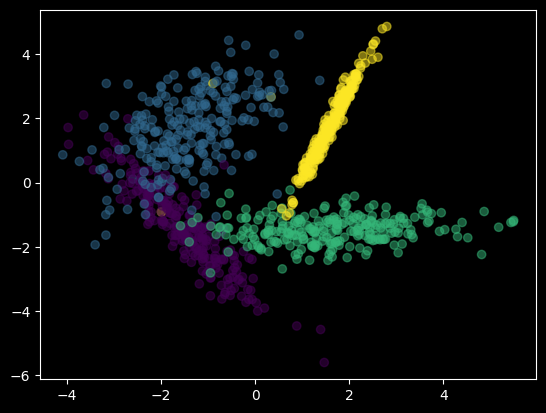

In [307]:
X, y = make_classification(n_samples=1000, n_classes=4, n_clusters_per_class=1,
                           shuffle=False, class_sep=1.5)

# Or, to use just 2 dimensions:
# X, y = make_classification(n_samples=1000, n_classes=4, n_clusters_per_class=1,
#                            shuffle=False, class_sep=1.5, n_features=2,
#                            n_informative=2, n_redundant=0, n_repeated=0)

print(f"X: {X.shape}\ny: {y.shape}")

plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.5)
plt.show()

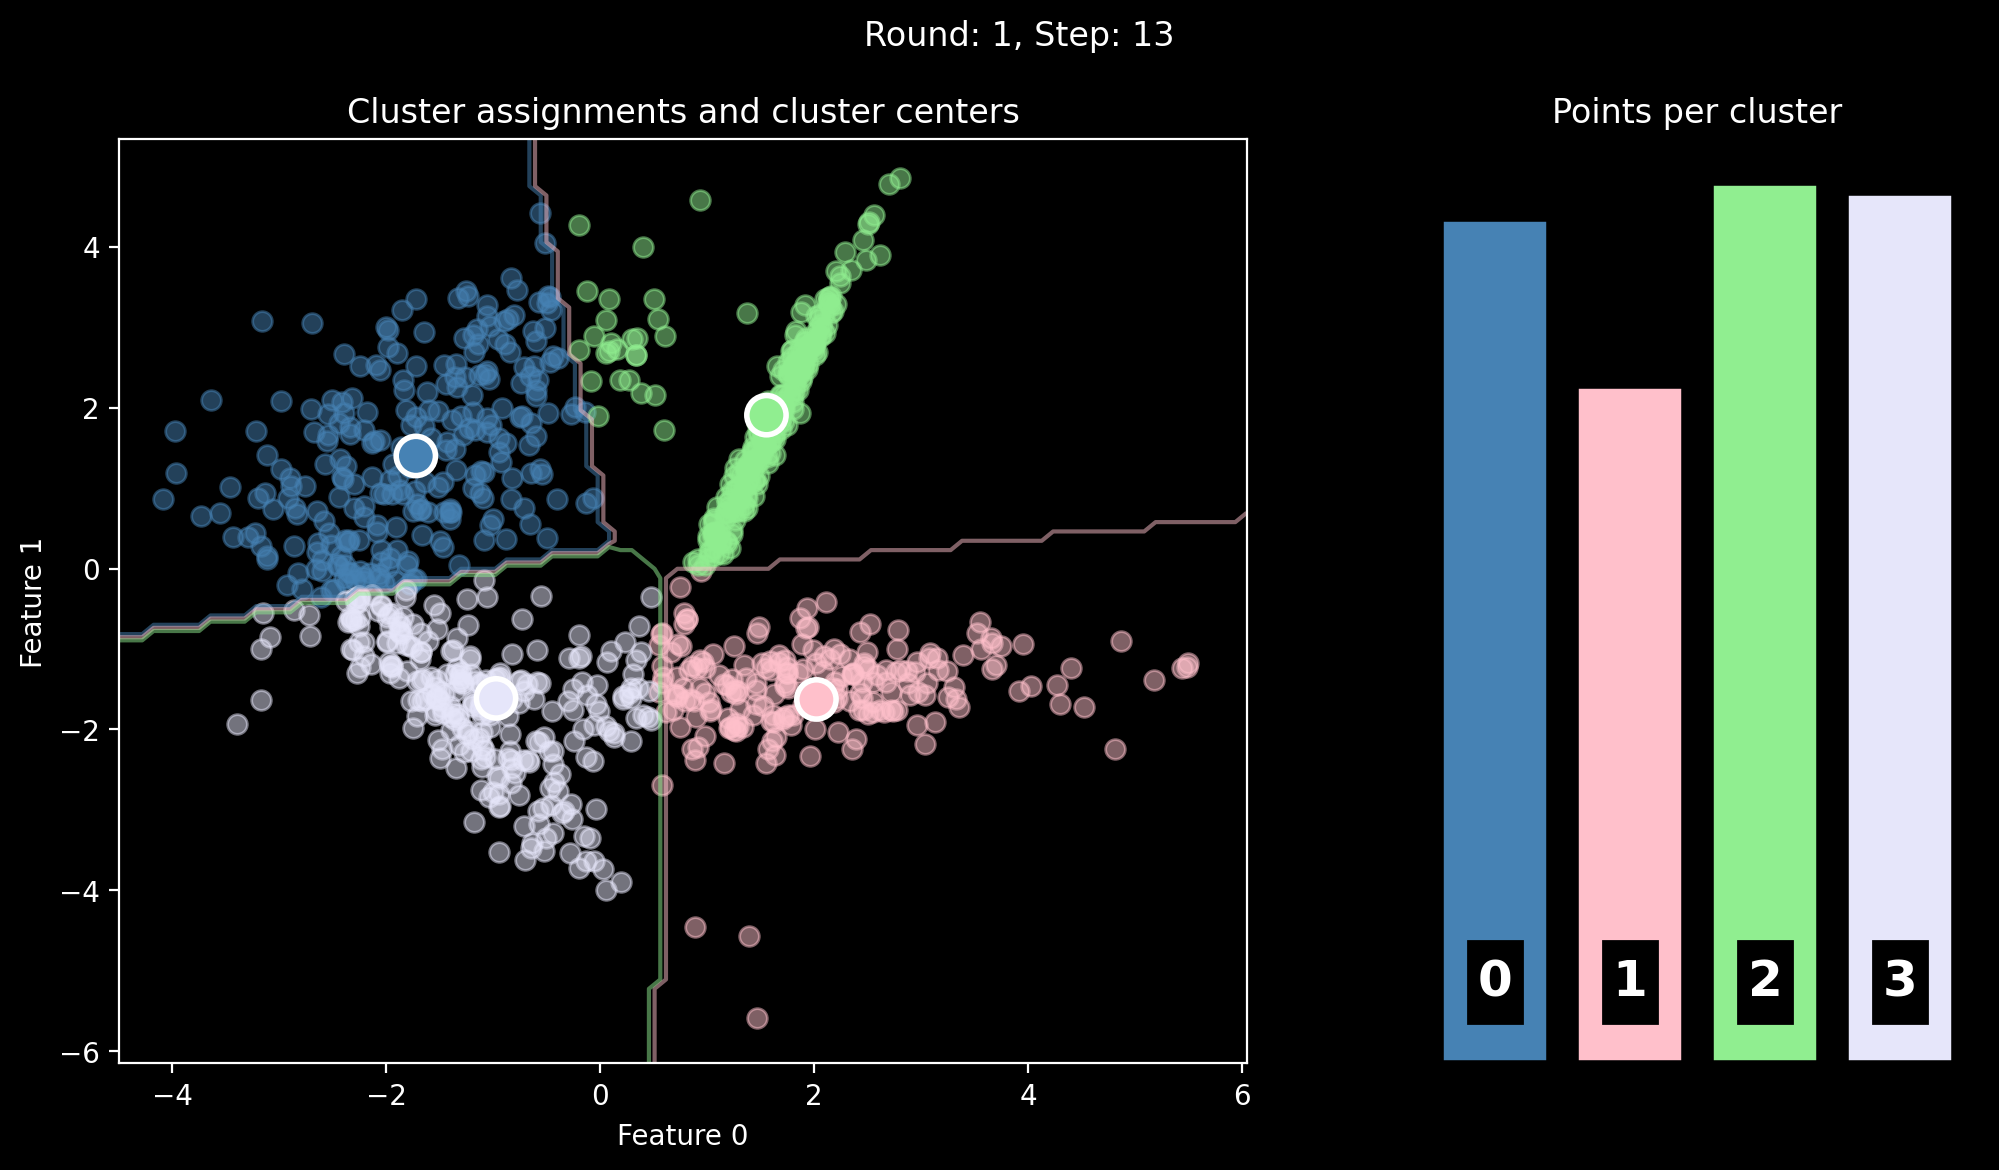

In [309]:
kmeans = KMeans(k=4, verbose=False, save_hist=True)
kmeans.fit(X)
print(f"Best round: {kmeans.best_round_}")

kmeans.plot_scatter(X, colors=['steelblue', 'pink', 'lightgreen', 'lavender'],
                    show_boundary_lines=False, show_cluster_regions=False)

# For animation:
# kmeans.plot_animate(X, colors=['steelblue', 'pink', 'lightgreen', 'lavender'],
#                     show_boundary_lines=True, show_cluster_regions=False,
#                     fps=1.0, save_img_folder_path = 'kmeans_images')




# One way to make an animation of the plot is to use the `imageio` library to create a .gif of the frames
# See: https://gist.github.com/awaelchli/7928b6a5525028bc8257b2dc3eefbee7
# See: https://towardsdatascience.com/probably-the-easiest-way-to-animate-your-python-plots-f5194ebed75f
# %pip install imageio
# import imageio
# num_digits = len(str(len(self.hist_)))
# with imageio.get_writer('kmeans.mp4', mode='i', fps=1.0) as writer:
#     for i in range(len(self.hist_)):
#         img = imageio.imread(f"kmeans_images/kmeans_{str(i).zfill(num_digits)}")
#         writer.append_data(img)

# OR, you can use a web service like: https://gifmaker.me/

## Color palette generation from image

In [312]:
def download_img(url: str) -> np.ndarray:
    '''Download an image from a given URL and return it as a NumPy array.'''
    # Reference: https://stackoverflow.com/questions/40911170/python-how-to-read-an-image-from-a-url/40911414#40911414
    with urllib.request.urlopen(url) as image_file:
        img = Image.open(image_file)
    return np.array(img)

Shape of image: (400, 400, 3)


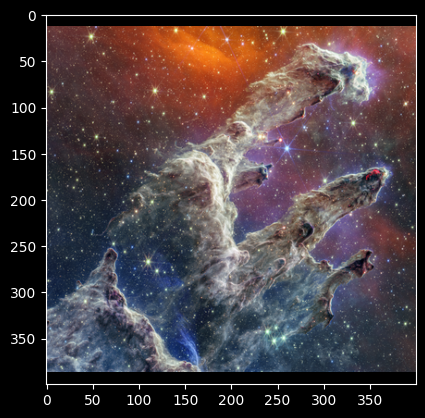

In [321]:
# img_array = download_img('https://yongsungkimart.com/cdn/shop/products/YK1010323_221d11a0-9a07-4fd6-add5-92a10dd9b6dc_1024x1024@2x.jpg?v=1645570775')
img_array = download_img('https://stsci-opo.org/STScI-01GK2KMF48QFNZ28G9A9WQ0H52.png')
# img_array = download_img('https://stsci-opo.org/STScI-01G77PM8QXPC2SJFVNK54S0YVA.png')


print(f"Shape of image: {img_array.shape}")
plt.imshow(img_array)
plt.show()

In [322]:
kmeans = KMeans(k=4, verbose=True, max_iter=20, save_hist=True)
kmeans.fit(img_array)
print(f"Best round: {kmeans.best_round_}")

Reshaping input data from: (400, 400, 3) to (160000, 3)


  0%|          | 0/10 [00:00<?, ?it/s]

Round 0, max iter (20) reached. Proceeding to next round.
Round 1, max iter (20) reached. Proceeding to next round.
Round 2, max iter (20) reached. Proceeding to next round.
Round 3, max iter (20) reached. Proceeding to next round.
Round 4, max iter (20) reached. Proceeding to next round.
Round 5, max iter (20) reached. Proceeding to next round.
Round 6, max iter (20) reached. Proceeding to next round.
Round 7, max iter (20) reached. Proceeding to next round.
Round 8, max iter (20) reached. Proceeding to next round.
Round 9, max iter (20) reached. Proceeding to next round.
Best round: 8


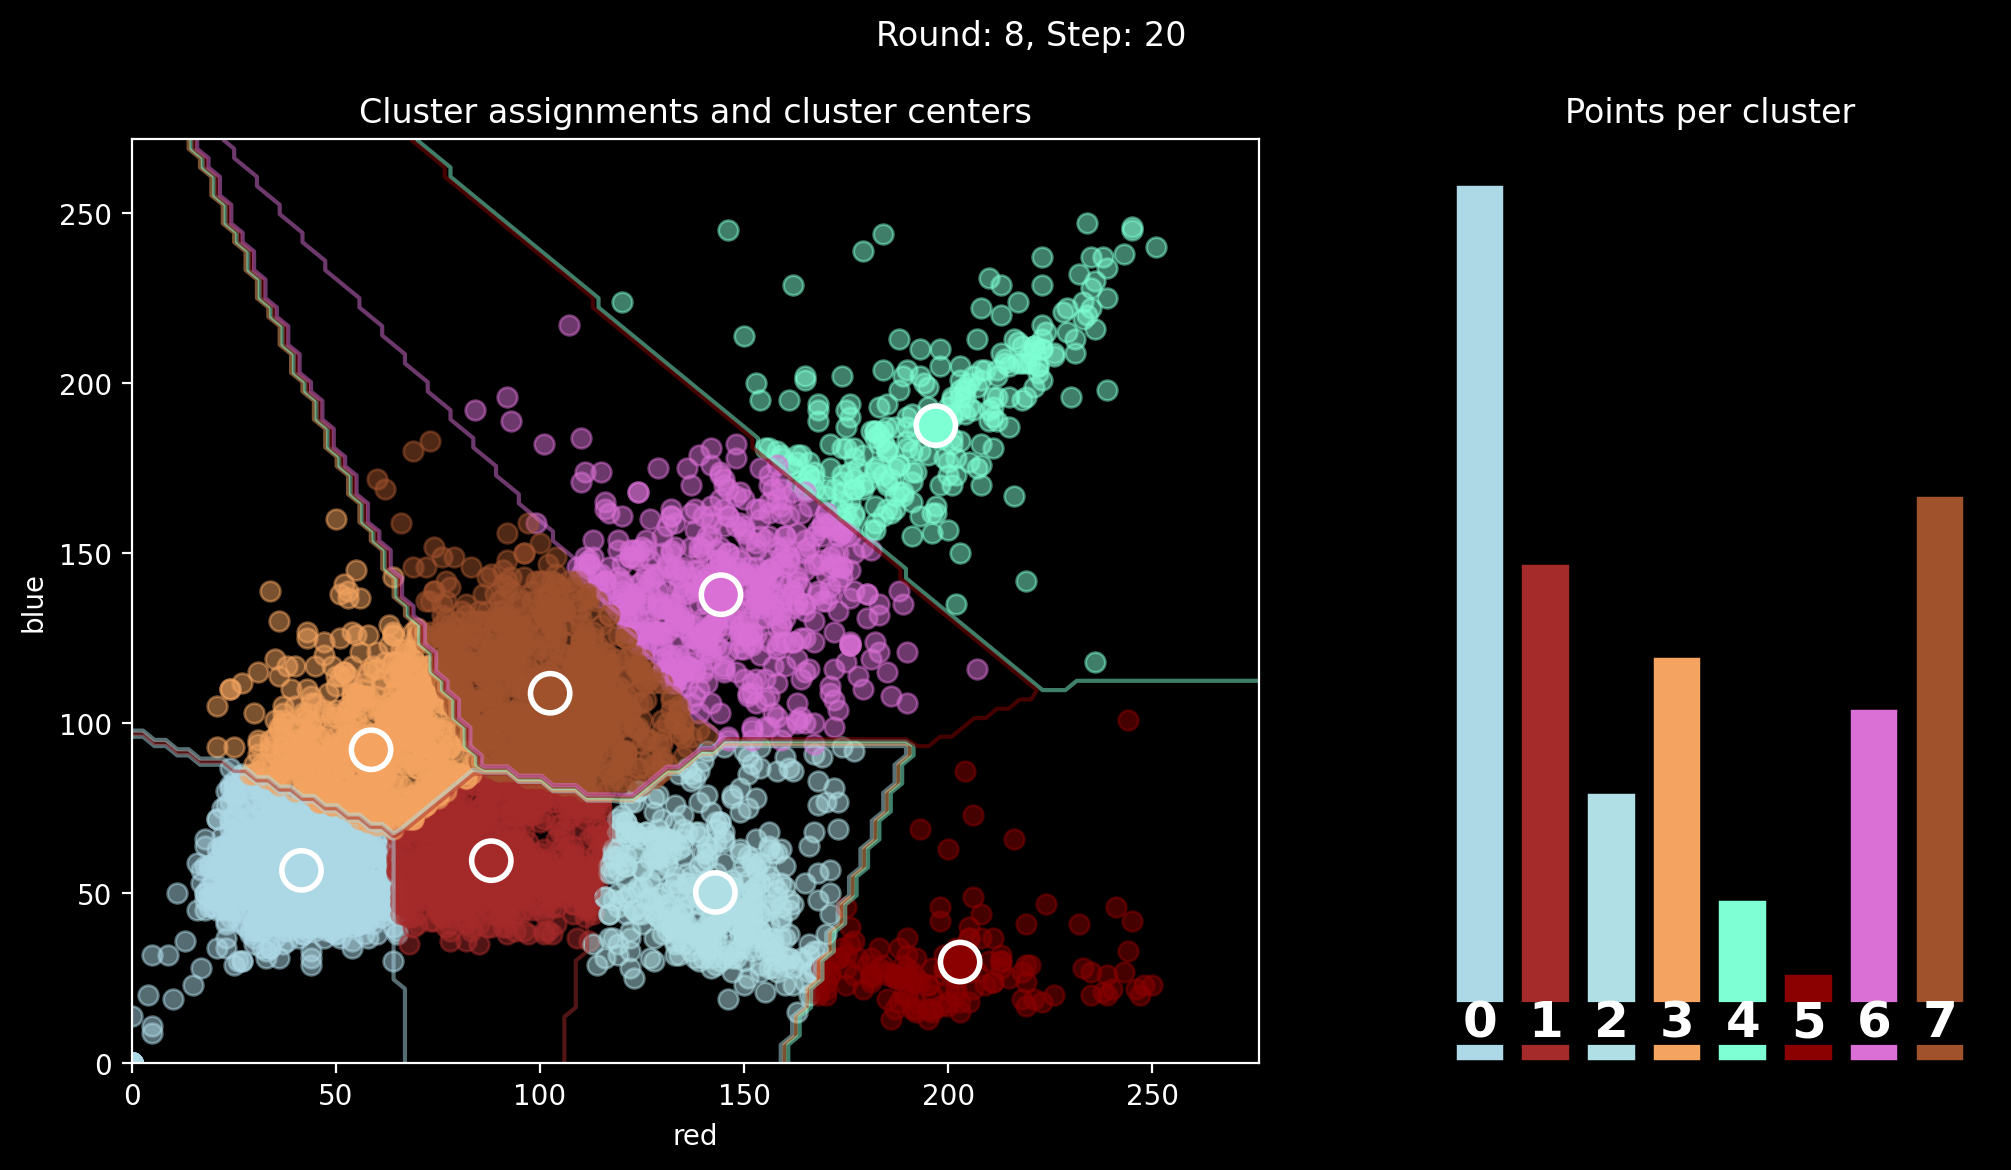

In [324]:
# kmeans.plot_scatter(img_array, colors=['steelblue', 'pink', 'lightgreen', 'lavender'],
#                     features_selected=[0, 2], feature_names=['red', 'blue'],
#                     show_boundary_lines=False, show_cluster_regions=False)

# For animation:
print(f"Total number of iterations: {kmeans.num_iters_}")
two_d_array = kmeans._preprocess(img_array, normalize=False)
if two_d_array.shape[0] > 5000:
    rng = np.random.default_rng()
    two_d_array = rng.choice(two_d_array, 5000)
kmeans.plot_animate(two_d_array, colors=['steelblue', 'pink', 'lightgreen', 'lavender'],
                    features_selected=[0, 2], feature_names=['red', 'blue'],
                    show_boundary_lines=True, show_cluster_regions=False,
                    fps=1.0)  # , save_img_folder_path = 'kmeans_images')

In [304]:
labels = kmeans.classify(img_array)
labels.shape

Reshaping input data from: (400, 400, 3) to (160000, 3)


(400, 400)

# K-Means, step by step
This section shows how K-Means is built out, step by step, with comments explaining the vectorized operations.

In [185]:
k = 4  # Set the number of clusters

# Sample one point for each of the cluster centers
rng = np.random.default_rng()
centers = rng.choice(X, size=k, replace=False, shuffle=False)

print(f"Shape of cluster centers: {centers.shape}")
print(f"Transpose and add a row dimension for broadcasting: {centers.T[np.newaxis, :, :].shape}")

Shape of cluster centers: (4, 20)
Transpose and add a row dimension for broadcasting: (1, 20, 4)


In [194]:
# Add a cluster dimension (dim 3) to the X array to store the distance of each
# cluster center to the data point at each of the point's dimensions.
# Add a row dimension (dim 1) to the transposed centers array to broadcast down
# the rows of the X array.
distances = (X[..., np.newaxis] - centers.T[np.newaxis, ...])**2
# .sum(axis=1) finds the distance from each point to each cluster center, returns a 2d array
# .argmin(axis=1) finds the closest cluster center, returns a 1d array
labels = distances.sum(axis=1).argmin(axis=1)

print(f"Shape of distances array: {distances.shape}")
print(f"Shape of labels array: {labels.shape}")

Shape of distances array: (1000, 20, 4)
Shape of labels array: (1000,)


The cell below uses vectorized operations to compute the new cluster means by indexing into the `X` array and computing the mean for each cluster across all the samples (rows) in `X`.

This is a loop equivalent:

```python
centers = []
for i in range(k):
    centers.append(X[labels==i].mean(axis=0))
```

In [195]:
# Create a boolean one-hot-encoding of the closest cluster center for each point
indices = np.eye(k, dtype='bool')[labels]
print(f"Shape of indices: {indices.shape}")

# Index the X array to compute the new mean based the cluster assignments
# cluster_assignments is a 3d array: (rows, columns, clusters), where dim 3 is
# 0s where the cluster was not assigned and equal to the column values at the
# assigned cluster.
cluster_assignments = (X[..., np.newaxis] * indices[:, np.newaxis, :])
centers = cluster_assignments.mean(axis=0, where=(cluster_assignments != 0)).T
print(f"Shape of cluster centers: {centers.shape}")

Shape of indices: (1000, 4)
Shape of cluster centers: (4, 20)


## Visualize cluster assignments

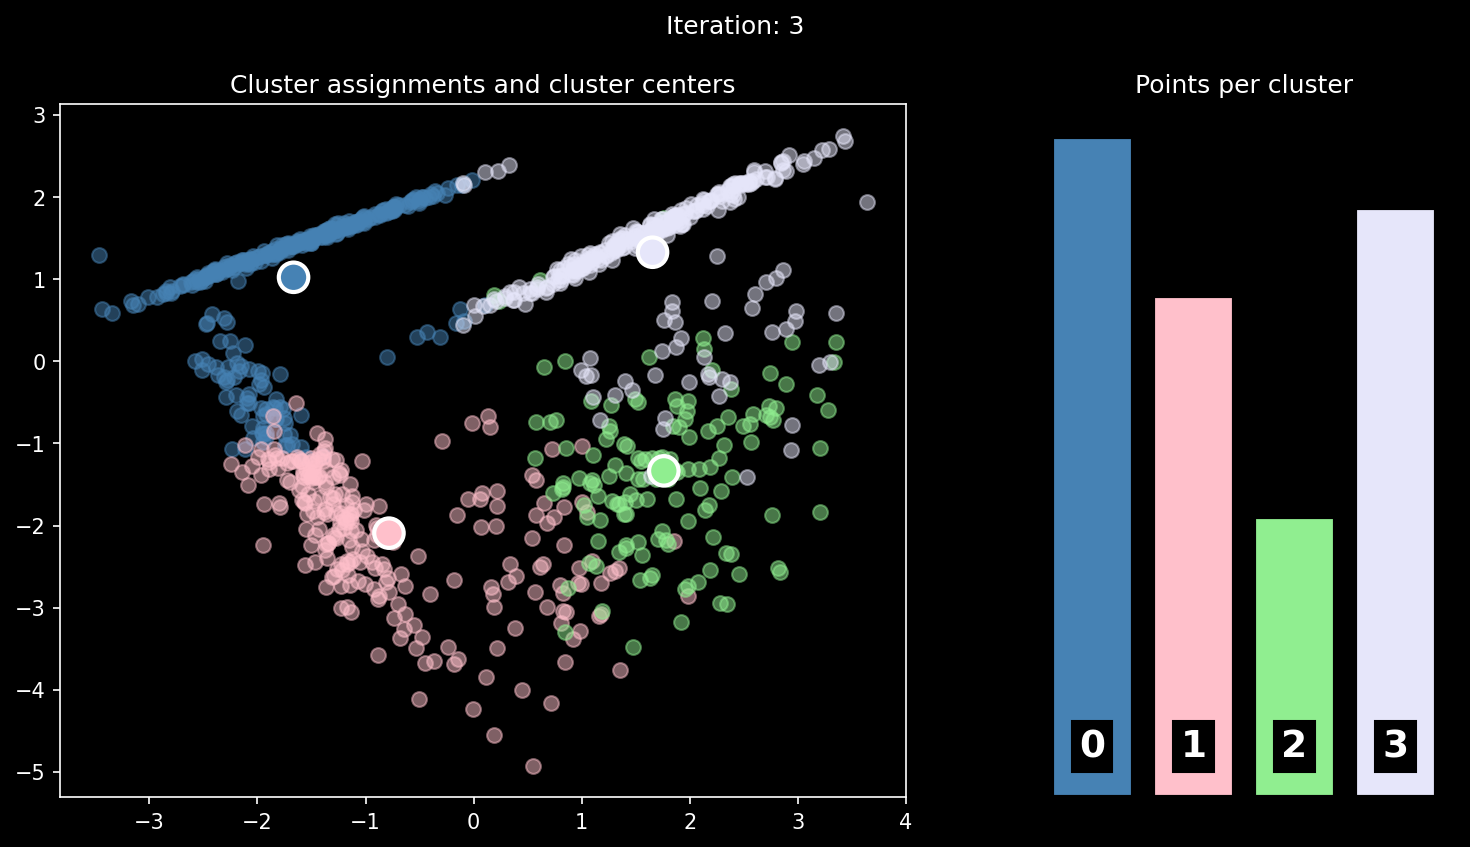

In [196]:
fig, axs = plt.subplots(nrows=1, ncols=2, dpi=150, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})

step_num = 3  # the iteration for the algorithm

# Select k random colors for plotting
rng = np.random.default_rng()
colors = rng.choice(list(matplotlib.colors.CSS4_COLORS.keys()), size=k, replace=False)
colors = ['steelblue', 'pink', 'lightgreen', 'lavender']

counts = np.eye(k, dtype='int')[labels].sum(axis=0)
for i in range(k):
    # Plot the points and their categories
    row_mask = (labels == i)
    axs[0].scatter(X[row_mask, 0], X[row_mask, 1], s=50, color=colors[i], alpha=0.5, label=i)
    # Plot the distribution of labels
    axs[1].bar(x=i, height=counts[i], color=colors[i], edgecolor='k', linewidth=2, label=i)
    y_midpoint = (len(labels) / k) / 2
    x_midpoint = k / 2
    axs[1].add_patch(Rectangle((i - x_midpoint/10, y_midpoint/10), x_midpoint/5, y_midpoint/5, color='black'))
    axs[1].text(x=i, y=y_midpoint/5, s=i, fontweight='bold', fontsize='18',
            ha='center', va='center', color='white')

# Plot the center points on top of everything else
axs[0].scatter(centers[:, 0], centers[:, 1], color=colors, edgecolor='white',
               s=200, linewidth=2, alpha=1.0, label="centers")

axs[0].set_title('Cluster assignments and cluster centers')
axs[1].set_title('Points per cluster')
axs[1].axis('off')
# plt.legend()
fig.suptitle(f"Iteration: {step_num:,.0f}")
plt.show()

# Utilities

## Check if arrays are broadcastable
While implementing the K-means algorithm, I often reshaped arrays to get them to align so operations would be broadcastable. I found [a helpful one-liner on Stack Overflow that checks whether arrays are broadcastable](https://stackoverflow.com/questions/47243451/checking-if-two-arrays-are-broadcastable-in-python/47244284#47244284). The function below uses that one-liner.

In [28]:
def can_broadcast(a, b):
    '''Check whether arrays a and b can be broadcast together.'''
    return all((m == n) or (m == 1) or (n == 1) 
               for m, n in zip(a.shape[::-1], b.shape[::-1]))

In [39]:
a = np.array([[1, 1, 1], [2, 2, 2]])
b = np.array([3, 3, 3]).reshape((1, 1, -1))
print("a:", a.shape)
print(a)
print("\nb:", b.shape)
print(b)

print(f"\nCan a and b be broadcast? {can_broadcast(a, b)}")

print(f"a * b: {(a * b).shape}\n{a * b}")

a: (2, 3)
[[1 1 1]
 [2 2 2]]

b: (1, 1, 3)
[[[3 3 3]]]

Can a and b be broadcast? True
a * b: (1, 2, 3)
[[[3 3 3]
  [6 6 6]]]


# Experiments
Various calculations tested along the way to the finished algorithm.

How to index a single dimension in a 2d array, which is useful when computing the cluster means and the average distance of each point to its assigned cluster.

In [26]:
rng = np.random.default_rng()
a = np.arange(15).reshape((5, 3))
b = rng.integers(low=0, high=a.shape[1], size=5)
c = np.arange(a.shape[0])  # c is just an index of every row number

print(a)
print('-' * 30)
print(b)
print('-' * 30)
print(c)
print('-' * 30)

a[c, b]

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]]
------------------------------
[2 1 2 2 2]
------------------------------
[0 1 2 3 4]
------------------------------


array([ 2,  4,  8, 11, 14])

Or, using the `where` parameter:

In [34]:
indices = np.eye(a.shape[1])[b].astype(bool)
a[indices]

array([ 2,  4,  8, 11, 14])

In [35]:
indices

array([[False, False,  True],
       [False,  True, False],
       [False, False,  True],
       [False, False,  True],
       [False, False,  True]])

In [43]:
# Ignore the "mean of empty slice" RuntimeWarning issued by NumPy when a cluster has no points assigned to it
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [47]:
# If a cluster has no points assigned to it, the mean is undefined (NaN).
# Replace NaN with 0 using np.nan_to_num
np.nan_to_num(np.mean(a, axis=0, where=indices))

array([0.  , 4.  , 8.75])

## Full-history version
This version of the `KMeans` class records the complete training history, which can consume a lot of memory since the labels for all data points are stored for each step, for each clustering round.

In [ ]:
class KMeans():
    def __init__(
            self,
            k: int=5,
            n_rounds: int=10,
            threshold: float=0.001,
            cluster_axis: int=-1,
            save_hist: bool=False,
            verbose: bool=False,
            random_state=None) -> None:
        '''Create an object to perform K-Means clustering on a dataset.
        
        # Parameters
        `k`: int, default=5
            The number of clusters to create.
        `n_rounds`: int, default=10
            The number of rounds for the clustering algorithm to run, each
            starting with randomly-chosen initial centers. The best-performing
            run will be returned, as determined by the set of clusters that
            minimizes the average squared distance between points and cluster
            centers.
        `threshold`: float, default=0.001
            Set the stopping criteria for model fit: if the average change
            for all cluster centers from the previous iteration to the current
            iteration is below this threshold, the algorithm will have converged
            and no futher iterations will be peformed in the current round.
            Note that the dataset is normalized on a scale of 0-1 prior to
            running the algorithm, so this convergence criteria applies to data
            on that scale. The default threshold of 0.001 is a 0.1% change in
            cluster centers on each dimension.
        `cluster_axis`: int, default=-1
            The axis to use for clustering; all other axes will be treated as
            samples in the row dimension. The KMeans algorithm uses
            a two-dimensional dataset: each row is a sample, and the columns
            are the features for that sample. If the given dataset has
            more than two axes, the data will be reshaped into 2-D prior to
            fitting the KMeans algorithm. The cluster_axis parameter sets the
            axis that will be used as the columns axis for clustering; all other
            axes will be reshaped into the row dimension. For example, an image
            has 3 axes: height, width, RGB. By default, KMeans will reshape
            the height and width axes into the row dimension and will use the
            RGB values as columns, thus creating a reshaped array of shape:
            (height x width, 3) where the clusters are pixels in RGB space.
        `save_hist`: bool, default=False
            Whether to save the results of each training iteration during model
            fit, including assigned labels for each sample. Use only when you
            plan to create plots of training progress, since this increases the
            memory used by the KMeans object.
        `verbose`: bool, default=False
            If `True`, print outputs showing the progress of model fit.
        `random_state`: int, default=None
            If set, this value will be used as the seed when initializing
            cluster centers.
        
        # Attributes
        `centers_`: the centers of the `k` clusters based on the best
            fit learned after performing `n_rounds` of the algorithm.
        `distances_`: the average distance (vector norm) from each cluster
            center to the points assigned to that cluster.
        `hist_`: a dictionary storing the results from all training iterations.
            Only available if `save_hist=True`.

        # Methods
        `fit(X)`: train the model to learn the best cluster centers based on
            a dataset (`X`, a NumPy array)
        `classify(X)`: assign cluster labels to data based on the cluster
            centers learned through `fit()`
        `predict(X)`: alias for `classify(X)`
        `plot_scatter()`: display a Matplotlib scatter plot of the clusters.
            Requires `save_hist` to be set to `True` prior to model fit.
        `plot_animate()`: display an animated Matplotlib scatter plot showing
            training progress and final cluster assignments. Requires
            `save_hist` to be set to `True` prior to model fit.
        '''
        # Store arguments passed on instantiation
        self.__dict__.update(locals())
        self.hist_ = {0: {
            'labels': {0: []},
            'centers': {0: []},
            'distances': {0: []},
            'num_iters_until_converged': 0
            } 
        }

        self.labels_ = np.array([])
        self.centers_ = np.array([])
        self.distances_ = np.array([])
    

    def _preprocess(self, data):
        '''Normalize data and ensure it is in the proper 2-D format.'''
        if data.ndim == 1:
            raise ValueError("Dataset must have ≥2 dimensions; provided dataset has 1 dimension.")
        if data.ndim > 2 or self.cluster_axis not in [-1, data.ndim - 1]:
            if self.verbose: print(f"Reshaping input data from: {data.shape} to ", end='')
            data = np.reshape(data, (-1, data.shape[self.cluster_axis]))
            if self.verbose: print(f"{data.shape}")
        # Normalize data on a scale of 0-1
        data = (data - self.data_min) / (self.data_max - self.data_min)
        return data


    def classify(
            self,
            data: np.ndarray,
            preserve_input_shape: bool=True) -> np.ndarray:
        '''Classify each sample (row) in a dataset by labeling the sample
        with the cluster whose center is nearest to it.

        Returns a NumPy array with the cluster assigned to each sample.

        # Parameters
        `data`: `numpy.ndarray`
            The data to be classified. Must be 2-dimensional or `preprocess`
            must be set to `True` (default).
        `preserve_input_shape`: bool, default=True
            If `True` (default), the returned array will match the shape of
            the input data if ndims > 2. If `False` or if ndims == 2, a 1-D
            array will be returned with the cluster label for each sample, where
            the number of samples is given by the row dimension in the input
            data; or, if the data has >2 dimensions, the number of samples is
            given by the product of the shape of all axes of the input data
            besides the `cluster_axis` that is set at object initialization.
        '''
        if data.ndim == 1:
            raise ValueError("Dataset must have ≥2 dimensions; given dataset has 1 dimension.")
        if preserve_input_shape:
            cluster_axis = self.cluster_axis if self.cluster_axis != -1 else data.ndim - 1
            input_shape = tuple(data.shape[i] for i in range(data.ndim) if i != cluster_axis)
        if self.centers_.size == 0:
            raise AssertionError("You need to fit the model before you can perform classification. Run KMeans.fit(X) on a dataset first.")

        data = self._preprocess(data)

        # ================================
        # Compute distance to each cluster
        # ================================
        # Add a cluster dimension to the data array to store the distance of each
        # cluster center at each of the data points' dimensions.
        # Add a row dimension to the transposed centers array to broadcast down
        # the rows of the data array.
        # distances is a 3d array: (num_samples, num_features, num_clusters)
        distances = (data[..., np.newaxis] - self.centers_.T[np.newaxis, ...])**2

        # =============================================
        # Assign labels based on nearest cluster center
        # =============================================
        # .sum(axis=1) finds the distance from each point to each cluster center, returns a 2d array
        # .argmin(axis=1) finds the closest cluster center, returns a 1d array
        labels = distances.sum(axis=1).argmin(axis=1)

        if preserve_input_shape:
            return labels.reshape(input_shape)
        else:
            return labels
    

    # Create aliases for classify()
    __call__ = classify  # Enables calling the object like a function
    predict = classify


    def fit(self, data: np.ndarray) -> None:
        '''Learn cluster labels based on a dataset.

        After fitting the model, assign labels to the dataset by running
        `classify(X)`, which returns a NumPy integer array with the label for
        each sample (row) in the provided dataset, `X`.
        
        # Parameters
        `data`: `numpy.ndarray`
            The input array, to be used for grouping into clusters.
        '''
        self.best_round = 0  # the round with the lowest avg distance from points to assigned cluster centers
        
        # Store max and min values of training data, used for normalizing
        self.data_min = data.min()
        self.data_max = data.max()

        data = self._preprocess(data)

        if self.verbose:
            pbar = tqdm(total=self.n_rounds)

        for round in range(self.n_rounds):
            self.hist_[round] = {
                'labels': {0: []},
                'centers': {0: []},
                'distances': {0: []},
                'num_iters_until_converged': 0
                }
            if self.random_state:
                # Increment the random state each iteration to change starting
                # point selection while maintaining deterministic behavior
                self.random_state += 1
            rng = np.random.default_rng(seed=self.random_state)

            # ===============================
            # Select starting cluster centers
            # ===============================
            # Sample one point for each of the cluster centers; array shape: (num_clusters, num_features)
            centers = rng.choice(data, size=self.k, replace=False, shuffle=False)

            i = 0
            converged = False
            while not converged:
                if self.verbose:
                    pbar.set_description(f"Round {round + 1}/{self.n_rounds}, iter {i}")
                
                self.hist_[round]['centers'][i] = centers

                # ================================
                # Compute distance to each cluster
                # ================================
                # Add a cluster dimension to the data array to store the distance of each
                # cluster center at each of the data points' dimensions.
                # Add a row dimension to the transposed centers array to broadcast down
                # the rows of the data array.
                # distances is a 3d array: (num_samples, num_features, num_clusters)
                distances = (data[..., np.newaxis] - centers.T[np.newaxis, ...])**2

                # ==============================================
                # Label each sample based on the nearest cluster
                # ==============================================
                # .sum(axis=1) finds the distance from each point to each cluster center, returns a 2d array (num_samples, num_clusters)
                # .argmin(axis=1) finds the closest cluster center, returns a 1d array (num_samples)
                labels = distances.sum(axis=1).argmin(axis=1)
                self.hist_[round]['labels'][i] = labels
                
                # =================================
                # Determine the new cluster centers
                # =================================
                # Create a boolean one-hot-encoding of the closest cluster center for each point.
                # Returns a 2d array of shape: (num_samples, num_clusters)
                indices = np.eye(self.k, dtype='bool')[labels]

                # Index the data array to compute the new mean based on the cluster assignments
                # cluster_assignments is a 3d array: (num_samples, num_features, num_clusters), where dim 3 is
                # 0s where the cluster was not assigned and equal to the column values at the assigned cluster.
                cluster_assignments = (data[..., np.newaxis] * indices[:, np.newaxis, :])
                centers = cluster_assignments.mean(axis=0, where=(cluster_assignments != 0)).T

                # Calculate the average distance from each point to its cluster center
                avg_dist = np.sum(distances, axis=1) ** 0.5
                avg_dist = np.mean(avg_dist, axis=0, where=indices)
                self.hist_[round]['distances'][i] = avg_dist
                # avg_dist = avg_dist[np.arange(data.shape[0]), labels]  # Index to the cluster assigned for each point
                
                # =========================================
                # Step 5: check for convergence
                # =========================================
                if i > 0:
                    converged = np.all(np.mean(np.abs(centers - self.hist_[round]['centers'][i-1])) < self.threshold)
                i += 1

            # Exit loop when converged and store the number of iterations
            self.hist_[round]['num_iters_until_converged'] = i - 1

            # Store the best-performing round; starting with round 0
            if round == 0:
                best_avg_distance = np.mean(avg_dist)
            else:
                avg_distance = np.mean(avg_dist)
                if avg_distance < best_avg_distance:
                    best_avg_distance = avg_distance
                    self.best_round = round
            
            if self.verbose:
                pbar.update()  # update at end of round
        
        # Store values from the best-performing round
        final_iter = self.hist_[self.best_round]['num_iters_until_converged']
        self.labels_ = self.hist_[self.best_round]['labels'][final_iter]
        self.centers_ = self.hist_[self.best_round]['centers'][final_iter]
        self.distances_ = self.hist_[self.best_round]['distances'][final_iter]

        if self.verbose:
            pbar.close()  # remove progress bar
